# Hello team!


In the last notebook, I mocked up how I would work with the hurdat2 data to make a shapefile showing the wind speeds for the hurricane. When I did this, I constructed a quadliteral with sides X nautical miles away from the center of the storm.

However, this isn't actually how the NOAA constructs their data. If we go to the file below, NOAA provides an example of how Irma's windfield was constructed on their end.

https://www.nhc.noaa.gov/gis/

If we look at their shape, we can notice it's a circle with four quadrants of unequal radii.


Text(0.5, 1.0, 'Example Hurricane Irma Shapefile Made by NOAA')

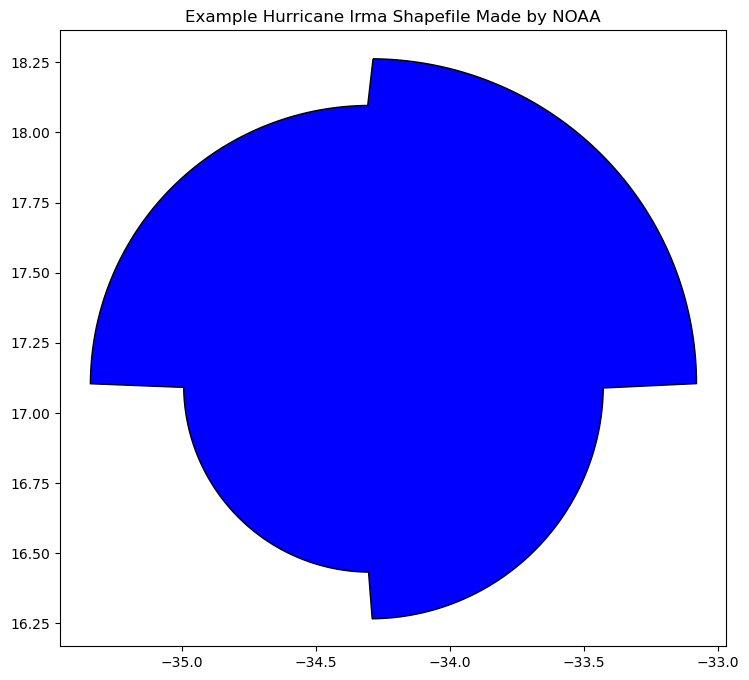

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt 

shapes = gpd.read_file(r'/Users/jackogozaly/Downloads/al112017_best_track/AL112017_radii.shp')
shapes = shapes[shapes['RADII'] == 34]
shapes = shapes[shapes['SYNOPTIME'] == '2017083118']

#This is just for decoration
fig, ax = plt.subplots(figsize=(10,8))
hurricane = gpd.GeoSeries(shapes['geometry'])
hurricane.plot(ax=ax, color='blue', edgecolor='black')
plt.title("Example Hurricane Irma Shapefile Made by NOAA")


Hence, this notebook correcting my mistakes, and proposing a different way for you all to construct these shapefiles.

## New Functions

In [5]:
#Used for dealing with our dataframe
import pandas as pd
#Using for finding lat and long coords X nautical miles out
import geopy 
import geopy.distance
from geopy.distance import geodesic
#Used for drawing circles
from numpy import cos,sin,arccos
import numpy as np
#Used for polygon shenanigans
import shapely
from shapely.geometry import Polygon
from shapely.geometry import shape
from shapely.ops import unary_union
#Used for visualizing
import geopandas as gpd


#I lifted these two circle functions from this stackoverflow post
#https://stackoverflow.com/questions/11331854/how-can-i-generate-an-arc-in-numpy
def parametric_circle(t,xc,yc,R):
    x = xc + R*cos(t)
    y = yc + R*sin(t)
    return x,y

def inv_parametric_circle(x,xc,R):
    t = np.arccos(((x-xc)/R))
    return t


def hurricane_shapefile(df, storm_id, wind_speed = 34, quadrant_points = 30):
    '''
    Parameters
    ----------
    df : pandas dataframe
        Hurdat 2 data.
    storm_id : string
        storm ID from hurdat.
    wind_speed : int, possible values are 34, 50, and 64
        DESCRIPTION. The default is 34.
    quadrant_points : INT, # of points in each arc
        DESCRIPTION. The default is 30.

    Returns
    -------
    List of non-empty polygons for the given hurricane
    
    '''
    #Empty list to store our shapes
    storm_shapes = []
    #Bearing for our wind directions
    bearings = [0, 90, 180, 270]
    
    #Subset for our storm
    sub_df = df[df['id'] == storm_id]
    
    for i in range(len(sub_df)):
        #Get the center of our storm
        latitude = sub_df['latitude'].iloc[i]
        longitude = sub_df['longitude'].iloc[i]
        center = geopy.Point(latitude, longitude)
        
        wind_columns = [f'{wind_speed}kt_wind_radii_NE_quad', 
                        f'{wind_speed}kt_wind_radii_SE_quad',
                        f'{wind_speed}kt_wind_radii_SW_qud', 
                        f'{wind_speed}kt_wind_radii_NW_qud']
        
        #Empty list to store the quadrant shapefiles
        quadrant_shapes = []
        for j in range(4):
            wind_miles = sub_df[wind_columns[j]].iloc[i]
            
            if wind_miles == 0:
                continue
            
            #Get the two points that make up the ends of our arc
            p1 = geodesic(nautical = wind_miles).destination(point=geopy.Point(latitude, longitude), bearing= bearings[j])
            p2 = geodesic(nautical = wind_miles).destination(point=geopy.Point(latitude, longitude), bearing= (bearings[j] + 90))
            
            #Treat our radius different depending on the quadrant
            if j == 0:
                radius = (p1.latitude - center.latitude) 
            if j ==1:
                radius = (p2.latitude - center.latitude) * -1
            elif j==2:
                radius = (p1.latitude - center.latitude) 
            elif j==3:
                radius = (p2.latitude - center.latitude) * -1
            
            #Convert our start and end points into tuples
            start_point = tuple([p1.latitude, p1.longitude])
            end_point = tuple([p2.latitude, p2.longitude])
            #Draw our semi-circle
            start_t = inv_parametric_circle(start_point[0], latitude, radius)
            end_t = inv_parametric_circle(end_point[0], latitude, radius)
            arc_T = np.linspace(start_t, end_t, quadrant_points)
            #Get the points from our circle
            X,Y = parametric_circle(arc_T, latitude, longitude, radius)
            points  = list(tuple(zip(Y, X)))
            #Insert the center of the storm as a first point so we can make the polygon
            points.insert(0, (longitude, latitude))
            #Create our polygon
            sub_poly = shapely.geometry.shape({'type': "Polygon", "coordinates": [points]})
            #Append to our list
            quadrant_shapes.append(sub_poly)
            
        #Union together each quadrant to form a circle-ish
        storm_shapes.append(unary_union(quadrant_shapes))
    #Remove any records that had 0 for all wind radii
    storm_shapes = [i for i in storm_shapes if not i.is_empty]
    
    return(storm_shapes)


I feel like this looks scary but it's actually really cool. We can easily get the shapefiles for our different wind speeds now.

In [6]:
hurricane_df = pd.read_csv(r'https://raw.githubusercontent.com/JackOgozaly/Hurricane_Crop_Acreage/main/Data/historical_hurricane_date.csv')

#Use our function for the different wind speeds
hurricane_irma_ts = hurricane_shapefile(hurricane_df, 'AL112017', wind_speed=34)
hurricane_irma_tc = hurricane_shapefile(hurricane_df, 'AL112017', wind_speed=50)
hurricane_irma_h = hurricane_shapefile(hurricane_df, 'AL112017', wind_speed=64)

### Fancier Plotting

And below is a fancier version of the wind speed plot

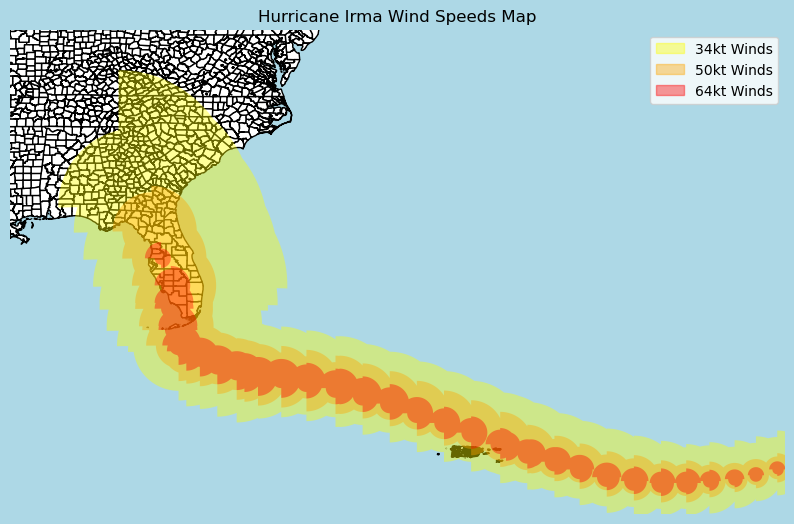

In [7]:
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches

county_shapes = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip')


#plt.style.use('default')
fig, ax = plt.subplots(figsize=(10,8))

#Create our county shapefiles and plot them
counties = gpd.GeoSeries(county_shapes['geometry'])
counties.plot(ax=ax, color='white', edgecolor='black')

irma_shape = unary_union(hurricane_irma_ts)
p = gpd.GeoSeries(irma_shape)
p.plot(ax=ax, color = "yellow", alpha = .4)

irma_shape2 = unary_union(hurricane_irma_tc)
p2 = gpd.GeoSeries(irma_shape2)
p2.plot(ax=ax, color = "orange", alpha = .4)


irma_shape3 = unary_union(hurricane_irma_h)
p3 = gpd.GeoSeries(irma_shape3)
p3.plot(ax=ax, color = "red", alpha = .4)


#This is also just for decoration
plt.xlim([-90, -50])
plt.ylim([15, 40])
plt.axis('off')
plt.title("Hurricane Irma Wind Speeds Map")
fig.patch.set_facecolor('lightblue')
ax = plt.gca()
ax.patch.set_facecolor('white')

#Creating our legend manually
legend1 = mpatches.Patch(color='yellow', label='34kt Winds', alpha =.4)
legend2 = mpatches.Patch(color='orange', label='50kt Winds', alpha =.4)
legend3 = mpatches.Patch(color='red', label='64kt Winds', alpha =.4)
plt.legend(handles=[legend1, legend2, legend3])


If you look closer at this map, it becomes obvious that the 6 hour time window for the hurricane forecast is prone to cause gaps in the map. I leave this problem for you all to solve!! (if it even is an issue)

# Reading Crop Data


A little unrelated, but I wanted to show you all an easy way to read in the crop acreage data from online. It's a little slow because the data is so large, but tbh I think this is easier, especially if you all are going to be having to compare year over year or what not.

***as a little bit of a warning, if you keep spamming the USDA site for the data, you might get blocked, so just stagger your pulls***



In [8]:
import pandas as pd
from io import BytesIO
from zipfile import ZipFile
import requests

def get_zip(file_url):
    url = requests.get(file_url)
    zipfile = ZipFile(BytesIO(url.content))
    files = [zipfile.open(file_name) for file_name in zipfile.namelist()]
    return files.pop() if len(files) == 1 else files

site = 'https://www.fsa.usda.gov/Assets/USDA-FSA-Public/usdafiles/NewsRoom/eFOIA/crop-acre-data/zips/2021-crop-acre-data/2021_fsa_acres_web_as_of_080221.zip'

df = get_zip(site)
df= pd.read_excel(df, sheet_name=4)

print(df.head())

   State Code  County Code  Crop Code    State   County  State County Code  \
0           1            1         11  Alabama  Autauga               1001   
1           1            1         11  Alabama  Autauga               1001   
2           1            1         11  Alabama  Autauga               1001   
3           1            1         16  Alabama  Autauga               1001   
4           1            1         21  Alabama  Autauga               1001   

             Crop        Crop Type Intended Use Irrigation Practice  \
0           WHEAT  SOFT RED WINTER        Grain                   I   
1           WHEAT  SOFT RED WINTER        Grain                   N   
2           WHEAT  SOFT RED WINTER         Seed                   N   
3            OATS           WINTER        Grain                   N   
4  COTTON  UPLAND              NaN        Blank                   I   

   Planted Acres  Volunteer Acres  Failed Acres  Prevented Acres  \
0         281.00              0.0   